# Clean CNRA data

Perform supplementary data cleaning tasks on shortage stage information in CNRA data; in this notebook, performing extensive string cleaning tasks on shortage stage. These stage descriptions vary significantly across water utilities, requiring significant cleaning to standardize across dataset. Initial cleaning steps on other variables performed in "calwater_cleaning" notebook.

In [2]:
# Import relevant packages
import pandas as pd
import numpy as np

import os

import geopandas
from shapely.geometry import Point

import re

import datetime as dt

import matplotlib.pyplot as plt
import matplotlib.animation as ani
import matplotlib.font_manager as font_manager
import seaborn as sns

from PIL import Image

from scipy.stats import gaussian_kde
from scipy.stats import kstest
from scipy.stats import ks_2samp
from scipy import stats

from sklearn import linear_model
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
from statsmodels.formula.api import ols

import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
# from linearmodels import PanelOLS

proj_path = os.path.dirname(os.path.dirname(os.path.abspath('calwater_shortage.ipynb')))

dr_path = proj_path + r"/calwater_data_raw"
dc_path = proj_path + r"/calwater_data_clean"

calwater_output = proj_path + r"/calwater_output"

In [3]:
calwater_comp_imp = pd.read_csv(dc_path + r"/calwater_data.csv")

calwater_comp_imp.head()

,supplier_name,supplier_name2,population,tot_waterprod_exclag,share_resid,county,hydrologic_region,for_profit,date,ag_calc_waterprod,shortage_stage,calculated_r_gpcd,private,nonprofit,month,log_gpcd,public,owner
0,adelanto city of,adelanto city of,31765.0,124032544.0,0.710,San Bernardino,South Lahontan,0.0,2014-09-15,0.0,NaN,92.4110,NaN,0.0,9,4.526246,1.0,2.0
1,adelanto city of,adelanto city of,29855.0,94182732.0,0.730,San Bernardino,South Lahontan,0.0,2020-02-15,0.0,NaN,79.4107,NaN,0.0,2,4.374633,1.0,2.0
2,adelanto city of,adelanto city of,29545.0,92091927.0,0.750,San Bernardino,South Lahontan,0.0,2019-11-15,0.0,NaN,77.9251,NaN,0.0,11,4.355748,1.0,2.0
3,adelanto city of,adelanto city of,29707.0,105007792.0,0.655,San Bernardino,South Lahontan,0.0,2017-11-15,0.0,3,77.1761,NaN,0.0,11,4.346090,1.0,2.0
4,adelanto city of,adelanto city of,30044.0,151747574.0,0.600,San Bernardino,South Lahontan,0.0,2019-07-15,0.0,NaN,97.7583,NaN,0.0,7,4.582498,1.0,2.0


In [38]:
calwater_comp = calwater_comp_imp.copy()

calwater_comp['short_clean'] = calwater_comp['shortage_stage']

calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('III', '3')
calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('II', '2')
calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace(' I ', '1')
calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('^(I)$', '1', regex=True)

calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('[Oo][Nn][Ee]', '1', regex=True)
calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('[Ff][Ii][Rr][Ss][Tt]', '1', regex=True)
calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('second', '2', regex=True)
calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('[Tt]wo', '2', regex=True)
calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('[Tt]hree', '3', regex=True)
calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('[Ff]our', '3', regex=True)
calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('[Zz]ero', '0', regex=True)

calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('^([Nn]\/[Aa]).*', '0', regex=True)
calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('^([Nn]1).*', '0', regex=True)
# calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('^([Nn][Oo] [Ss]ta).*', '0', regex=True)
calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('^.*( no longer under).*', '0', regex=True)
calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('^([Nn]ormal).*', '0', regex=True)
calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('.*([Vv]oluntary).*', '1', regex=True)

# Voluntary rationing: https://docs.cpuc.ca.gov/published/REPORT/99158.htm
calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('.*(Rul[er ]+14[.]+1).*', '1', regex=True)
calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('.*(CPUC.* 14[.]+1).*', '1', regex=True)
calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('^([ ]*14[.]+1)$', '1', regex=True)

# Mild restriction on landscape watering: https://coolcalifornia.arb.ca.gov/tip/water-lg
calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('.*([Jj]an[a-z ]+1[0]?,[ ]?2010).*', '1', regex=True)
calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('^([Jj]an[a-z ]+2010)$', '1', regex=True)

calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('([Ss][TtAaEe]+[gta]+e[gv]?)', 'Stage', regex=True)

calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('.*(1(st)? [Ss]tage).*', '1', regex=True)
calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('.*(1(st)? [Ll]evel).*', '1', regex=True)
calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('.*(2(nd)? [Ss]tage).*', '2', regex=True)
calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('.*(3(rd)? [Ss]tage).*', '3', regex=True)
calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('.*(3(rd)? [Ll]evel).*', '3', regex=True)

calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('.*(1(st)? of 4).*', '1', regex=True)
calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('.*(2(nd)? of 4).*', '2', regex=True)
calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('.*(3(rd)? of 4).*', '3', regex=True)
calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('.*(4(th)? of 4).*', '4', regex=True)

calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('^(pahse 1).*', '1', regex=True)
calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('^([Pp][g]?[Hh]?[Aa][Ss]+[Ee] IV).*', '4', regex=True)
calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('^([Pp][g]?[Hh]?[Aa][Ss]+[Ee] 4).*', '4', regex=True)
calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('^([Pp][g]?[Hh]?[Aa][Ss]+[Ee] [1iI]).*', '1', regex=True)
calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('^([Pp][g]?[Hh]?[Aa][Ss]+[Ee] [2]).*', '2', regex=True)
calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('^([Pp][g]?[Hh]?[Aa][Ss]+[Ee] [3]).*', '3', regex=True)
calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('^([Pp][g]?[Hh]?[Aa][Ss]+[Ee] [5V]).*', '3', regex=True)


calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('([Ll][EeUe][Vv][Ee][Lld])', 'Level', regex=True)
calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('^(Water (Supply )?Shortage.* Level)', 'Level', regex=True)
calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('^.*(pdated.[Ll]evel 1)', '1', regex=True)
calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('^((Drought )?[Ll][Ee]ve[l]?[ ]?1.*[Mm]andatory).*', '2', regex=True)
calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('^((Drought )?[Ll][Ee]ve[l]? [1I]).*', '1', regex=True)
calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('^((Drought.*)?[Ll][Eue]ve[l]?[ ]?2).*', '2', regex=True)
calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('.*([Ll][Ee]ve[l] 2 Water Alert).*', '2', regex=True)
calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('^((Drought.*)?[Ll][Ee]ve[l]?[ ]?3).*', '3', regex=True)
calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('.*([Ll][Ee]ve[l] 0).*', '0', regex=True)
calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('.*([Ll][Ee]ve[l] 1).*', '1', regex=True)

calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('.*([Ss][Tt][Aa][Gg][Ee][ ]?[O0]).*', '0', regex=True)
calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('.*([Ss][Tt][Aa][Gg][Ee][ ]?( No. )?[1iI]).*', '1', regex=True)
calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('.*([Ss][Tt][Aa][Gg][Ee][ ]?2).*', '2', regex=True)
calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('^(Second( Stage)?)$', '2', regex=True)
calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('.*([Ss][Tt][Aa][Gg][Ee][ ]?3).*', '3', regex=True)
calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('.*([Ss][Tt][Aa][Gg][Ee][ ]?4).*', '4', regex=True)
calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('.*([Ss][Tt][Aa][Gg][Ee][ ]?6).*', '6', regex=True)
calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('.*([Ss][Tt][Aa][Gg][Ee][ ]?7).*', '7', regex=True)
calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('.*([Nn]o [Ss][Tt][Aa][Gg][Ee][ ]?)$', '0', regex=True)

# Assuming A-E stages similar to 1-5: https://codelibrary.amlegal.com/codes/beverlyhillsca/latest/beverlyhills_ca/0-0-0-11303
calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('.*([Ss][Tt][Aa][Gg][Ee][ ]?A).*', '1', regex=True)
calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('.*([Ss][Tt][Aa][Gg][Ee][ ]?B).*', '2', regex=True)
calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('.*([Ss][Tt][Aa][Gg][Ee][ ]?C).*', '3', regex=True)
calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('.*([Ss][Tt][Aa][Gg][Ee][ ]?D).*', '4', regex=True)
calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('.*([Ss][Tt][Aa][Gg][Ee][ ]?E).*', '5', regex=True)

# Stupid, nonsensical fucking color conversion: https://www.cvwd.com/ordinances
calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('^([Bb]lue)$', '1', regex=True)
calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('^(Green)$', '2', regex=True)
calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('^([Yy]ello[w]?)$', '3', regex=True)
calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('^([Oo]rang[we])$', '4', regex=True)
calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('^(Red)$', '5', regex=True)

# Assuming loose restrictions
calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('(.*[Qq]ualif.*[Ss]ta[tg]eme.*)', '1', regex=True)
calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('(.*[Qq]ualif.*[bB]elow.*)', '1', regex=True)
calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('(.*See Note found [bB]elow.*)', '1', regex=True)
calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('(.*CITY.*ORDINANCE.*)', '1', regex=True)
calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('^(Sta[mn]dard)$', '1', regex=True)
calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('^(.*Resolution 2016-18.* Water).*$', '1', regex=True)
calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('^(.*Water Use Efficiency Best Practices).*$', '1', regex=True) 
calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('^(.*Following Federal Contingency Guidelines).*$', '1', regex=True)
calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('^Advisory$', '1', regex=True)
calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('^(Conservation Rate)$', '1', regex=True)
calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('^yes$', '1', regex=True)

# Assuming tight restrictions
calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('(.*Rest[ricted ]+Use.*)', '2', regex=True)
calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('(.*Use Restriction.*)', '2', regex=True)
calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('(.*Temporary Water Restrictions.*)', '2', regex=True)
calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('(.*Baseline Level[ -]+Mandatory.*)', '2', regex=True)
calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('(.*[Mm]andat[ed ]+[Cc]omplian.*)', '2', regex=True)
calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('(.*Significant Water Supply Shortage.*)', '2', regex=True)
calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('^(.*Resolution 2015-16.* Water).*$', '2', regex=True)
calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('^(.*0 irrigation.*).*$', '2', regex=True)
calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('^Allocation$', '2', regex=True)
calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('^urgency measures$', '2', regex=True)
calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('^([Ss]ta[gt]e[s]?)( plan)?$', '2', regex=True)
calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace("^(Governor['s]+ Proclamation)$", '2', regex=True)

calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('^(1.?[ABCabc])$', '1', regex=True)
calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('^(01)$', '1', regex=True)
calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('^(1[- ]*[Mm]andatory)$', '1', regex=True)
calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('^(1[- ]*in progress).*$', '1', regex=True)
calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('^(1st)$', '1', regex=True)
calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('^(Notice of.*Level 1)$', '1', regex=True)
calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('^(2.?[ABCabc])$', '2', regex=True)
calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('^(2.?[ Municipal Code]).*$', '2', regex=True)
calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('^(2nd)$', '2', regex=True)
calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('^(2.[5]?)$', '2', regex=True)
calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('^(3.?[ABCabc])$', '3', regex=True)
calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('^(3rd)$', '3', regex=True)
calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('^(3.?)$', '3', regex=True)
calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('^(3.?[ABCabc]\:[ ]+Mand).*$', '3', regex=True)
calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('^(4.?[ABCabc])$', '4', regex=True)
calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('^(IV)$', '4', regex=True)
calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('^(4.?[ABCabc]\: Mand).*$', '4', regex=True)

calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('^(V)$', '5', regex=True)
calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('^(V2)$', '7', regex=True)

calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('^(0\, N1)$', '0', regex=True)
calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('^(0\, Normal)$', '0', regex=True)

calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('(["Pp]+ermanent.*)', '1', regex=True)
calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('^([Mm]andatory.*)$', '1', regex=True)

calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('^(Volunteer)$', '1', regex=True)
calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('^([Mm]inimal).*$', '1', regex=True)
calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('^([Mm]oderate).*$', '2', regex=True)
calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('^([Ss]ever[e]?ly [Rr]est).*$', '3', regex=True)\

calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('^([Ee]xtra[or]+dinary).*$', '5', regex=True)
calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('^(.*[Ee]mergency).*$', '5', regex=True)

# Based on mean shortage
calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('^Level$', '2', regex=True)
calwater_comp['short_clean'] = calwater_comp['short_clean'].str.replace('^S$', '0', regex=True)

calwater_comp['short_clean2'] = ''

calwater_comp['short_clean2'] = calwater_comp.loc[calwater_comp['short_clean'].str.len()==1, 'short_clean']
calwater_comp['short_clean2'] = calwater_comp['short_clean2'].str.replace('^[ABCSVlo]$', '', regex=True)

### Check that null shortage stage values are similar to 0 shortage stage when filling NaN stages with 0
### See next cell for test and interpretation
trial_null_orig = calwater_comp.copy()

calwater_comp.loc[calwater_comp['shortage_stage'].isnull(), 'short_clean2'] = '0'

calwater_comp['short_clean2'] = pd.to_numeric(calwater_comp['short_clean2'], errors='coerce')

print(calwater_comp['short_clean2'].count())

calwater_comp['short_clean2'].sort_values().unique()

calwater_comp.loc[calwater_comp['short_clean2'].isnull(), 'shortage_stage'].sort_values().unique()

calwater_comp.head()

30177


,supplier_name,supplier_name2,population,tot_waterprod_exclag,share_resid,county,hydrologic_region,for_profit,date,ag_calc_waterprod,shortage_stage,calculated_r_gpcd,private,nonprofit,month,log_gpcd,public,owner,short_clean,short_clean2
0,adelanto city of,adelanto city of,31765.0,124032544.0,0.710,San Bernardino,South Lahontan,0.0,2014-09-15,0.0,NaN,92.4110,NaN,0.0,9,4.526246,1.0,2.0,NaN,0.0
1,adelanto city of,adelanto city of,29855.0,94182732.0,0.730,San Bernardino,South Lahontan,0.0,2020-02-15,0.0,NaN,79.4107,NaN,0.0,2,4.374633,1.0,2.0,NaN,0.0
2,adelanto city of,adelanto city of,29545.0,92091927.0,0.750,San Bernardino,South Lahontan,0.0,2019-11-15,0.0,NaN,77.9251,NaN,0.0,11,4.355748,1.0,2.0,NaN,0.0
3,adelanto city of,adelanto city of,29707.0,105007792.0,0.655,San Bernardino,South Lahontan,0.0,2017-11-15,0.0,3,77.1761,NaN,0.0,11,4.346090,1.0,2.0,3,3.0
4,adelanto city of,adelanto city of,30044.0,151747574.0,0.600,San Bernardino,South Lahontan,0.0,2019-07-15,0.0,NaN,97.7583,NaN,0.0,7,4.582498,1.0,2.0,NaN,0.0


### Test that NaN shortage values are similar to shortage stage 0

Below, I review null shortage values; ultimately, because average water consumption (given by ln(GPCD)) is actually higher when shortage stage is null (per test p-value below), we can reasonably conclude that null values reflect periods during which there is not a water crisis.

4.705556495776678

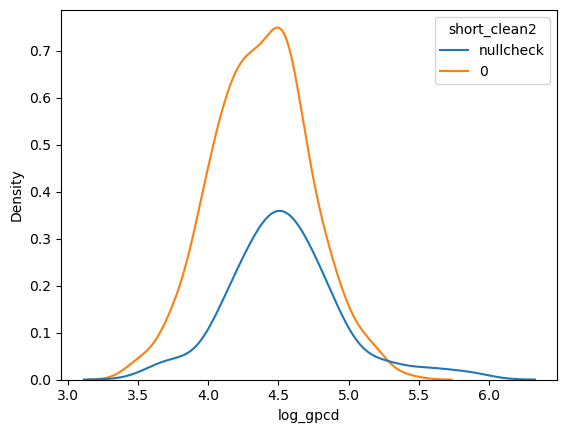

In [40]:
trial_null = trial_null_orig[(trial_null_orig['short_clean2'].isin(['0', np.nan])) & 
                             (trial_null_orig['month']==11)]

trial_null = trial_null[['short_clean2', 'log_gpcd']]

trial_null['short_clean2'] = trial_null['short_clean2'].fillna('nullcheck')

sns.kdeplot(x='log_gpcd', hue='short_clean2', data=trial_null)

t_statistic, p_value = stats.ttest_ind(trial_null.loc[trial_null['short_clean2']=='nullcheck', 'log_gpcd'], 
                                       trial_null.loc[(trial_null['short_clean2']=='0'), 'log_gpcd'], alternative='greater')

t_statistic

In [158]:
### Review GPCD values at various shortage stages

calwater_comp.loc[(calwater_comp['county'].isin(['San Bernardino', 'Los Angeles', 'Kern'])), ['short_clean2', 'log_gpcd']].groupby(['short_clean2']).mean()

,log_gpcd
short_clean2,
0.0,4.543458
1.0,4.487619
2.0,4.466138
3.0,4.525377
4.0,4.479565
5.0,4.922945
6.0,4.661070
7.0,4.704032


### Create 'crisis' dummy variable and export for analysis in R

'Crisis' dummy to be used to investigate likelihood of being in a state of crisis. Exporting for R analysis because 41100 project analysis to be completed in R.

In [159]:

# calwater_comp.loc[calwater_comp['short_clean2'] > 1, 'crisis'] = 1
calwater_comp['crisis'] = calwater_comp['short_clean2'].isin([2,3,4,5,6,7]).astype(int)

calwater_comp.to_csv(dc_path + r"/calwater_data_shortage.csv")

In [1]:
# calwater_comp[calwater_comp['supplier_name2']=='california city city of'].sort_values('date')